In [98]:
#importing all the required libraries and modules
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight') 

import os

import seaborn as sns
from datetime import datetime, timedelta

from google.cloud import bigquery


import itertools

from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse, mean_absolute_error as mae
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import lightgbm as lgb

import gc, copy

from gensim.models import Word2Vec 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [99]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [100]:
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart Orlando' AND B.ACTV_NM = "ONLINE" and A.DRVR_USER_ID = "contreras_correia@hotmail.com"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])
df["ACTV_START_TS"] = df["ACTV_START_TS"] + pd.Timedelta(hours=3) #converting pacific time to eastern time (orlando market)
df["ACTL_ACTV_END_TS"] = df["ACTL_ACTV_END_TS"] + pd.Timedelta(hours=3)
df.head()

,DRVR_USER_ID,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY,ACTV_DT
0,contreras_correia@hotmail.com,2021-11-25 09:04:09.691,2021-11-25 09:05:06.584,0.950000000,2021-11-25
1,contreras_correia@hotmail.com,2021-11-25 08:32:07.297,2021-11-25 09:00:00.000,27.880000000,2021-11-25
2,contreras_correia@hotmail.com,2021-11-25 12:09:39.648,2021-11-25 12:10:54.513,1.250000000,2021-11-25
3,contreras_correia@hotmail.com,2021-11-25 12:31:56.482,2021-11-25 16:30:00.000,238.070000000,2021-11-25
4,contreras_correia@hotmail.com,2021-12-24 16:59:28.890,2021-12-24 17:03:08.108,3.670000000,2021-12-24


In [102]:
df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
time_line = time_line.to_series()
ts = pd.DataFrame(time_line,columns = ["dayhour"])
ts = ts.set_index("dayhour")
ts = pd.merge(ts,df,how="left",on=["dayhour"])
ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
ts = ts.set_index(["dayhour"],drop=True)
ts = ts.drop_duplicates()
ts = ts.dropna()
ts = ts.reset_index(drop=False)
ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
def create_final_data(df):
    df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
    df = df[df['minutes']>0].reset_index(drop=True)
    # create an IntervalIndex which we can set as the axis (needed for re-indexing).
    # subtract one minute from end_time so that the minute of the termination is excluded.
    iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                          df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                          closed='both')
    # create a new index with the extended frequency:
    new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
    # set the new index to get the extended frequency;
    # all minutes will have the value of the whole interval
    result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
    # we can now calculate the duration per hour by resampling and summing the
    # boolean representation of the duration (1/0):
    result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
    result.index.name = 'start_hour'
    return result
re = create_final_data(ts)
re = pd.DataFrame(re)
re

,minutes
start_hour,
2021-10-10 15:00:00,16
2021-10-10 16:00:00,60
2021-10-10 17:00:00,60
2021-10-10 18:00:00,60
2021-10-10 19:00:00,60
...,...
2022-07-11 18:00:00,60
2022-07-11 19:00:00,60
2022-07-11 20:00:00,60


In [111]:
re = re.loc[(re.index.hour <= 21) & (re.index.hour >= 6)]

<AxesSubplot:xlabel='start_hour'>

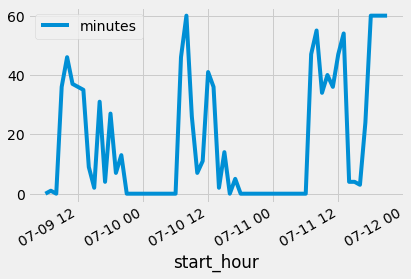

In [115]:
re.loc[(re.index >= "2022-07-09 01:00:00")].plot()

In [116]:
re.index

DatetimeIndex(['2021-10-10 15:00:00', '2021-10-10 16:00:00',
               '2021-10-10 17:00:00', '2021-10-10 18:00:00',
               '2021-10-10 19:00:00', '2021-10-10 20:00:00',
               '2021-10-10 21:00:00', '2021-10-11 06:00:00',
               '2021-10-11 07:00:00', '2021-10-11 08:00:00',
               ...
               '2022-07-11 12:00:00', '2022-07-11 13:00:00',
               '2022-07-11 14:00:00', '2022-07-11 15:00:00',
               '2022-07-11 16:00:00', '2022-07-11 17:00:00',
               '2022-07-11 18:00:00', '2022-07-11 19:00:00',
               '2022-07-11 20:00:00', '2022-07-11 21:00:00'],
              dtype='datetime64[ns]', name='start_hour', length=4391, freq=None)

In [117]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)),4))

In [118]:
re.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391 entries, 2021-10-10 15:00:00 to 2022-07-11 21:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   minutes  4391 non-null   int64
dtypes: int64(1)
memory usage: 68.6 KB


In [119]:
def Croston(ts,extra_periods=1,alpha=0.4):
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [120]:
pred_croston =  Croston(re.minutes, extra_periods = 10, alpha=0.4)

In [121]:
pred_croston

,Demand,Forecast,Period,Level,Error
0,16.0,16.000000,1.000000,16.000000,0.000
1,60.0,16.000000,1.000000,16.000000,44.000
2,60.0,33.600000,1.000000,33.600000,26.400
3,60.0,44.160000,1.000000,44.160000,15.840
4,60.0,50.496000,1.000000,50.496000,9.504
...,...,...,...,...,...
4396,NaN,54.361521,1.001759,54.457151,NaN
4397,NaN,54.361521,1.001759,54.457151,NaN
4398,NaN,54.361521,1.001759,54.457151,NaN
4399,NaN,54.361521,1.001759,54.457151,NaN


In [122]:
pred_croston = pred_croston.Forecast.head(len(re))

print('RMSE: ' + str(my_rmse(re.minutes,pred_croston)))
#print('MAE: ' + str(mae(re.minutes,pred_croston)))

RMSE: 25.4663


<AxesSubplot:xlabel='start_hour'>

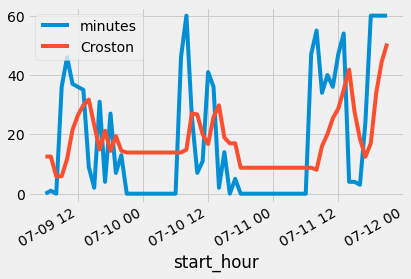

In [123]:
re['Croston'] = pred_croston.values
re.loc[(re.index >= "2022-07-09 01:00:00")].plot()

In [124]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [125]:
pred_croston_tsb =  Croston_TSB(re.minutes, extra_periods = 10, alpha = 0.1, beta = 0.1)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(re))
print('RMSE: ' + str(my_rmse(re.minutes,pred_croston_tsb)))

RMSE: 21.1397


In [126]:
pred_croston_tsb

0       16.000000
1       16.000000
2       20.400000
3       24.360000
4       27.924000
          ...    
4386    20.716234
4387    21.064456
4388    24.452202
4389    27.597276
4390    30.505688
Name: Forecast, Length: 4391, dtype: float64

<AxesSubplot:xlabel='start_hour'>

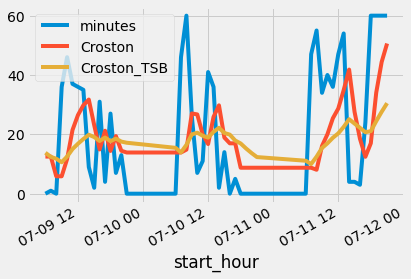

In [127]:
re["Croston_TSB"] =  pred_croston_tsb.values
re.loc[(re.index >= "2022-07-09 01:00:00")].plot()

In [128]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pylab as plab

from sklearn.model_selection import train_test_split

In [129]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import macrodata

In [130]:
split_date = '01-Jun-2022'
ts_train = re.loc[re.index <= split_date].copy()
ts_test = re.loc[re.index > split_date].copy()

In [131]:
ts_train

,minutes,Croston,Croston_TSB
start_hour,,,
2021-10-10 15:00:00,16,16.000000,16.000000
2021-10-10 16:00:00,60,16.000000,16.000000
2021-10-10 17:00:00,60,33.600000,20.400000
2021-10-10 18:00:00,60,44.160000,24.360000
2021-10-10 19:00:00,60,50.496000,27.924000
...,...,...,...
2022-05-31 17:00:00,17,33.751881,25.520089
2022-05-31 18:00:00,46,28.253926,25.144330
2022-05-31 19:00:00,60,34.528709,26.948746


In [132]:
len(ts_test)

656

In [135]:
stlf = STLForecast(ts_train['minutes'], ARIMA, model_kwargs={"order": (0, 1, 5)}, period = 15)
res = stlf.fit()
forecasts = res.forecast(656)

C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\V0V01S7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported inde

In [136]:
forecasts

3735     5.130360
3736    15.572681
3737    21.094993
3738    47.841233
3739    30.984162
          ...    
4386    39.329680
4387    22.853456
4388    50.123055
4389    48.263691
4390    29.001309
Length: 656, dtype: float64

In [137]:
forecasts[forecasts < 0] = 0
forecasts

3735     5.130360
3736    15.572681
3737    21.094993
3738    47.841233
3739    30.984162
          ...    
4386    39.329680
4387    22.853456
4388    50.123055
4389    48.263691
4390    29.001309
Length: 656, dtype: float64

In [138]:
#re.loc[(re.index >= "2022-07-09 01:00:00")].plot()
print('RMSE: ' + str(my_rmse(ts_test.minutes,forecasts)))

RMSE: 28.0562


In [139]:
print('MAE: ' + str(mae(ts_test.minutes,forecasts)))

MAE: 23.120968987312292


In [140]:
ts_test["SLTF_pred"] = forecasts
ts_test

,minutes,Croston,Croston_TSB,SLTF_pred
start_hour,,,,
2022-06-01 06:00:00,0,34.110071,30.524690,NaN
2022-06-01 07:00:00,0,34.110071,27.472221,NaN
2022-06-01 08:00:00,0,34.110071,24.724999,NaN
2022-06-01 09:00:00,46,34.110071,22.252499,NaN
2022-06-01 10:00:00,60,17.792559,24.297166,NaN
...,...,...,...,...
2022-07-11 17:00:00,24,12.437142,20.716234,NaN
2022-07-11 18:00:00,60,17.000346,21.064456,NaN
2022-07-11 19:00:00,60,34.061259,24.452202,NaN


In [141]:
ts_last = ts_test.loc[ts_test.index >= "2022-07-09 01:00:00"]

<AxesSubplot:xlabel='start_hour'>

<Figure size 432x288 with 0 Axes>

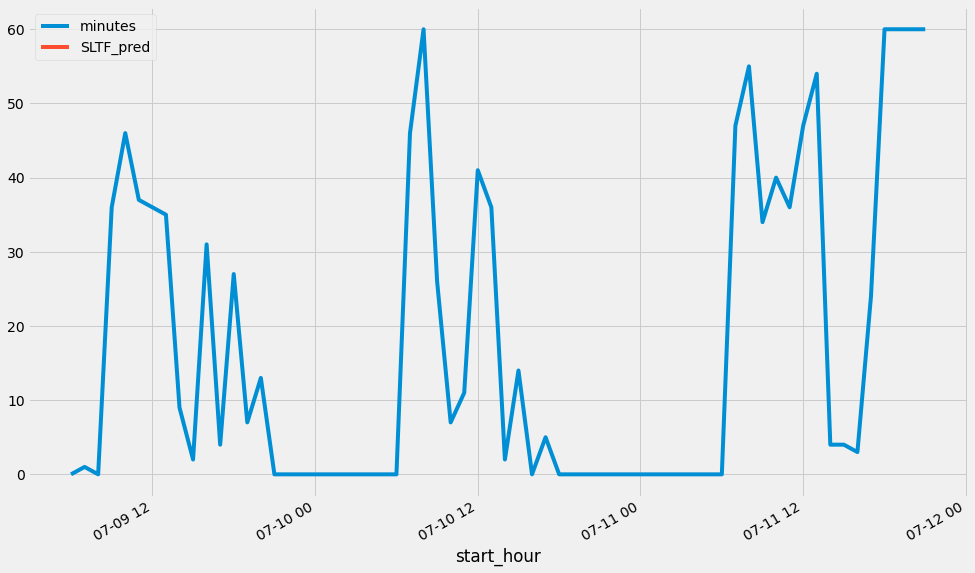

In [142]:
plt.figure()

ts_last.plot(y=["minutes","SLTF_pred"],figsize = (15,10))

In [92]:
ts_test.SLTF_pred.value_counts()

52.438917    41
6.345492     41
52.371167    41
16.061609    41
18.635834    41
41.972731    41
28.482064    41
45.320062    41
0.755756     41
4.455940     41
4.702392     41
4.958712     41
5.951654     40
5.748501     40
5.989992     40
5.487061     40
1.489311     40
1.720119     40
1.935668     40
5.221554     40
53.416589    40
49.838000    40
37.284184    40
16.323788    40
5.306926      1
5.199423      1
5.437352      1
5.038319      1
Name: SLTF_pred, dtype: int64

In [93]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts_train['minutes'],order=(0,1,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                minutes   No. Observations:                 5602
Model:                 ARIMA(0, 1, 5)   Log Likelihood              -23315.044
Date:                Mon, 11 Jul 2022   AIC                          46642.088
Time:                        15:03:18   BIC                          46681.872
Sample:                    10-10-2021   HQIC                         46655.952
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1525      0.014    -10.566      0.000      -0.181      -0.124
ma.L2         -0.2202      0.013    -16.549      0.000      -0.246      -0.194
ma.L3         -0.1623      0.013    -12.231      0.000      -0.188      -0.136
ma.L4         -0.2110      0.013    -16.126      0.000      -0.237      -0.185
ma.L5         -0.2196      0.015    -14.952      0.000      -0.248      -0.191
sigma2       241.5257      3.952     61.122      0.000     233.781     249.270
===================================================================================
Ljung-Box (L1) (Q):                   3.63   Jarque-Bera (JB):              1500.40
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

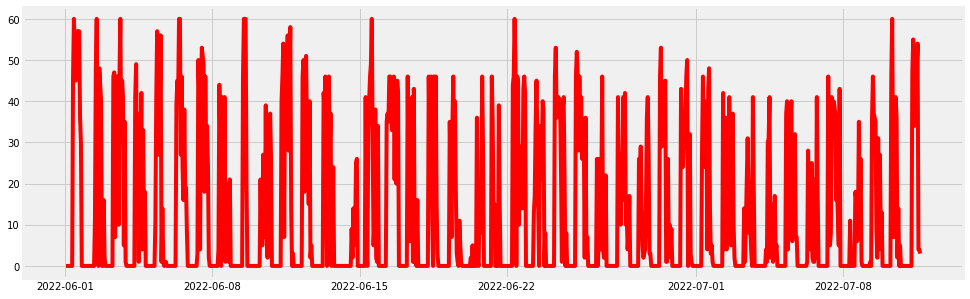

In [94]:
start=len(ts_train)
end=len(ts_train)+len(ts_test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)z
ax.plot(ts_test.index, ts_test['minutes'], color='r')

<AxesSubplot:>

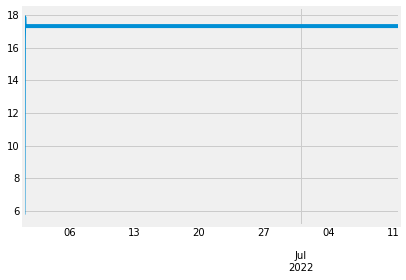

In [97]:
pred.plot()

In [95]:
ts_last = ts_test.loc[ts_test.index >= "2022-07-09 01:00:00"]

In [ ]:
plt.figure()

ts_last.plot(y=["minutes","SLTF_pred"],figsize = (15,10))